# Improving Training Speed

This notebook follows the same basic structure as the previous one, training a pre-trained model on reduced data.

We'll make a number of changes designed to make our model training MUCH faster.
Since PyTorch gives us so much control, our decisions can greatly increase or decrease training time.

### Package imports

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Imports for loading data into pytorch
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.io import read_image
from torchvision import transforms as T

# Imports for model training
from sklearn.model_selection import train_test_split
from torch import nn
import torch.optim as optim
import torchvision.models as models

## Load Data

Remember to edit the below paths to the data if needed.

In [2]:
data_root_dir = '/domino/datasets/Serengeti4kImages'
#data_root_dir = '/domino/datasets/local/Serengeti4kImages'
img_dir = os.path.join(data_root_dir, 'images')
metadata_file = os.path.join(data_root_dir, 'reduced_metadata.csv')

### Read in metadata and define training and test sets

In [3]:
# Read in metadata and ensure it is shuffled
metadata = pd.read_csv(metadata_file).sample(frac=1, random_state=42).reset_index(drop=True)
# Define mappings from label name to index, for 
category_name_to_id = {
    'zebra': 0,
    'giraffe': 1,
    'wildebeest': 2,
    'gazellethomsons': 3
}
category_id_to_name = {v: k for k,v in category_name_to_id.items()}
metadata['category_id'] = metadata['category_name'].apply(lambda x: category_name_to_id[x])
print(f"There are {len(metadata)} images total")
#metadata.head()

There are 4000 images total


In [4]:
# must be less than 1000
samples_per_class = 100

small_metadata = (
    metadata
    .groupby('category_name')
    .apply(pd.DataFrame.sample, n=samples_per_class, random_state=42)
    .reset_index(drop=True)
)
#small_metadata['category_name'].value_counts()

In [5]:
train_indices, val_indices = train_test_split(
    small_metadata.index,
    stratify=small_metadata['category_name'],
    test_size=0.2,
    random_state=42
)

In [6]:
small_train_metadata = small_metadata.iloc[train_indices].reset_index(drop=True)
#print("Train counts")
#small_train_metadata['category_name'].value_counts()

In [7]:
small_val_metadata = small_metadata.iloc[val_indices].reset_index(drop=True)
#print("Val counts")
#small_val_metadata['category_name'].value_counts()

### Create PyTorch Dataset and DataLoader

The `SnapshotSerengetiDataset` class definition is the same as used in the previous notebook.
Later in this notebook we'll make some performance improvements!

In [8]:
class SnapshotSerengetiDataset(Dataset):
    def __init__(self, img_metadata, img_dir, transform=None):
        # Do some basic validation
        required_columns = ['category_id', 'file_name']
        if not all([x in img_metadata.columns for x in required_columns]):
            raise Exception(f"img_metadata must be a dataframe including columns {', '.join(required_columns)}")
        if not os.path.isdir(img_dir):
            raise Exception("img_dir must be a valid directory")
        self.img_metadata = img_metadata
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_metadata)
        
    def __getitem__(self, idx):
        item_metadata = self.img_metadata.iloc[idx]
        image_path = os.path.join(self.img_dir, item_metadata['file_name'])
        image = read_image(image_path)
        image = torch.mul(image, 1/255.) # scale to [0, 1]
        if self.transform:
            image = self.transform(image)
        label_idx = item_metadata['category_id']
        one_hot_label = (
            torch.zeros(len(category_id_to_name), dtype=torch.float)
            .scatter_(dim=0, index=torch.tensor(label_idx), value=1)
        )
        return image, one_hot_label

In [9]:
#These resize and normalize transforms will allow our data to be used with pre-trained networks in later notebooks
standard_transform = T.Compose([
    T.Resize(256),
    T.CenterCrop(224),
    T.ConvertImageDtype(torch.float32),
    T.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

In [10]:
train_dataset = SnapshotSerengetiDataset(small_train_metadata, img_dir, transform=standard_transform)
val_dataset = SnapshotSerengetiDataset(small_val_metadata, img_dir, transform=standard_transform)

In [11]:
batch_size = 40
train_loader = DataLoader(train_dataset, batch_size=batch_size)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

## Transfer learning - using GPUs!

The first change we'll make is the addition of GPUs.
It's best practice to use a command like the one below instead of hard-coding GPUs, so your code can still run (very slowly!) on a cpu-only machine.
Then, just add a command to each of the training functions to move the model and data `to(device)`.

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [13]:
def load_pretrained_model():
    model = models.resnet50(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, len(category_id_to_name)) # Rescale fully-connected layer output size
    num_frozen_layers = 9

    # Freeze `num_frozen_layers`
    layer = 0
    for child in model.children():
        layer += 1
        if layer <= num_frozen_layers:
            for param in child.parameters():
                param.requires_grad = False
    print('Number of unfrozen layers: ' + str(layer-num_frozen_layers))
    return model.to(device)

In [14]:
def train(dataloader, model, loss_fn, optimizer, quiet=False):
    model.train() # Set model to training mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, num_correct = [], 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # String formatting choices here are tuned to this small sample
        if not quiet:
            print(f"Batch {batch+1}/{num_batches} loss: {loss.item():>7f}  [{(batch+1)*len(X):>3d}/{size:>3d}]")
        train_loss.append(loss.item())
        num_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    # Return final results for loss and accuracy
    avg_train_loss = np.mean(train_loss)
    train_accuracy = 100*num_correct/size
    print(f"Train Accuracy: {train_accuracy:>0.1f}%, Avg loss: {avg_train_loss:>8f}")
    return avg_train_loss, train_accuracy

In [15]:
def test(dataloader, model, loss_fn, quiet=False):
    model.eval() # Set model to evaluate mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, num_correct = [], 0
    with torch.no_grad():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)
            loss = loss_fn(pred, y)
            # String formatting choices here are tuned to this small sample
            if not quiet:
                print(f"Batch {batch+1}/{num_batches} loss: {loss.item():>7f}  [{(batch+1)*len(X):>3d}/{size:>3d}]")
            test_loss.append(loss.item())
            num_correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()
    avg_test_loss = np.mean(test_loss)
    test_accuracy = 100*num_correct/size
    print(f"Test Accuracy: {test_accuracy:>0.1f}%, Avg loss: {avg_test_loss:>8f}")
    return avg_test_loss, test_accuracy

### Model traing loop on GPUs

Let's run the same model training loop as the previous notebook, and see how much GPUs speed things up.
(Assuming the same reduced data set, same batch size, same models, we expect the previous notebook loop to have taken about 165 seconds while this cell takes about 55 seconds.)

In [16]:
model = load_pretrained_model()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-3)
n_epochs = 2
learning_curve = pd.DataFrame(index=range(n_epochs), columns=['train_loss', 'train_acc', 'val_loss', 'val_acc'])
since = time.time()
for epoch in range(n_epochs):
    print(f"=====Epoch {epoch+1}/{n_epochs}=====")
    train_loss, train_acc = train(train_loader, model, loss_fn, optimizer, quiet=True)
    val_loss, val_acc = test(val_loader, model, loss_fn, quiet=True)
    learning_curve.loc[epoch] = (train_loss, train_acc, val_loss, val_acc)
    print(f"Cumulative time elapsed: {time.time() - since:.1f}")
total_training_time = time.time() - since
print(f"-------------------------------\nDone! Total time elapsed: {total_training_time:.1f}s")

Number of unfrozen layers: 1
=====Epoch 1/2=====
Train Accuracy: 27.5%, Avg loss: 0.609574
Test Accuracy: 40.0%, Avg loss: 0.572357
Cumulative time elapsed: 25.9
=====Epoch 2/2=====
Train Accuracy: 50.9%, Avg loss: 0.562381
Test Accuracy: 60.0%, Avg loss: 0.511993
Cumulative time elapsed: 50.8
-------------------------------
Done! Total time elapsed: 50.8s


## Profiling

In software development, you don't want to put effort into making something faster unless you know that the part you are working on is the bottleneck.
Now that we have made the "obvious" improvement of using GPUs, we should do some more digging to find out what part of our code is the slowest.

Pytorch has some tools to help with this, but `line_profiler` is a great Jupyter extension to profile functions line-by-line.
Let's use it to dig into the train function.

In [17]:
# May need to run this cell if line profiler is not already installed
#!pip install line_profiler

In [18]:
%load_ext line_profiler

In [19]:
test_model = load_pretrained_model()
optimizer = optim.SGD(test_model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-3)

Number of unfrozen layers: 1


In [20]:
%lprun -f train train(train_loader, test_model, loss_fn, optimizer, quiet=True)

Train Accuracy: 29.7%, Avg loss: 0.610899


Timer unit: 1e-06 s

Total time: 20.0166 s
File: <ipython-input-14-41fa1fdfc354>
Function: train at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def train(dataloader, model, loss_fn, optimizer, quiet=False):
     2         1       1711.0   1711.0      0.0      model.train() # Set model to training mode
     3         1         19.0     19.0      0.0      size = len(dataloader.dataset)
     4         1         18.0     18.0      0.0      num_batches = len(dataloader)
     5         1          2.0      2.0      0.0      train_loss, num_correct = [], 0
     6         9   19659560.0 2184395.6     98.2      for batch, (X, y) in enumerate(dataloader):
     7         8      22781.0   2847.6      0.1          X, y = X.to(device), y.to(device)
     8                                                   
     9                                                   # Compute prediction error
    10         8     214265.0  26783.1

### Investigating data load performance

From the above profiling, we can see that the vast majority of time is being spent simply loading the data.
We can guess that the slowest part of the process will happen somewhere inside the `__get_item__` method of our dataset class, so let's write a benchmarking function to run through those steps separately.

In [21]:
def get_item_bench(idx):
    item_metadata = small_train_metadata.iloc[idx]
    image_path = os.path.join(img_dir, item_metadata['file_name'])
    image = read_image(image_path)
    image = torch.mul(image, 1/255.) # scale to [0, 1]
    image = standard_transform(image)
    label_idx = item_metadata['category_id']
    one_hot_label = (torch.zeros(len(category_id_to_name),dtype=torch.float)
                     .scatter_(dim=0, index=torch.tensor(label_idx), value=1))

In [22]:
%lprun -f get_item_bench get_item_bench(0)

Timer unit: 1e-06 s

Total time: 0.051844 s
File: <ipython-input-21-fec3ed2acf93>
Function: get_item_bench at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_item_bench(idx):
     2         1        566.0    566.0      1.1      item_metadata = small_train_metadata.iloc[idx]
     3         1         54.0     54.0      0.1      image_path = os.path.join(img_dir, item_metadata['file_name'])
     4         1      30270.0  30270.0     58.4      image = read_image(image_path)
     5         1      15577.0  15577.0     30.0      image = torch.mul(image, 1/255.) # scale to [0, 1]
     6         1       5237.0   5237.0     10.1      image = standard_transform(image)
     7         1         63.0     63.0      0.1      label_idx = item_metadata['category_id']
     8         2         52.0     26.0      0.1      one_hot_label = (torch.zeros(len(category_id_to_name),dtype=torch.float)
     9         1         25.0     

### Improving data load performance

About 2/3 of the time is spent on the `read_image` step, and most of the remaining 1/3 is spent on the image transformations.
Let's try modifying this function to **cache** transformed images directly in the pytorch tensor format.

Run the following benchmark twice to see the performance improvement between the first call (before the image is cached) and the second (after the image is cached).
Expect the first call to take about 0.1 seconds total (longer than the original function), while any subsequent call takes less than 0.005 seconds!

In [23]:
# Modify path as needed if not running this from a Domino project with a default dataset folder
test_cache_dir = f"/domino/datasets/local/Serengeti4kImages/test_image_cache"
if not os.path.isdir(test_cache_dir):
    os.mkdir(test_cache_dir)

In [24]:
def get_cached_item_bench(idx):
    item_metadata = small_train_metadata.iloc[idx]
    cache_path = os.path.join(test_cache_dir, item_metadata['file_name'] + '.pt')
    image_path = os.path.join(img_dir, item_metadata['file_name'])
    if not os.path.isfile(cache_path):    
        image = read_image(image_path)
        image = torch.mul(image, 1/255.) # scale to [0, 1]
        image = standard_transform(image)
        torch.save(image, cache_path)
    image = torch.load(cache_path)
    label_idx = item_metadata['category_id']
    one_hot_label = (torch.zeros(len(category_id_to_name), dtype=torch.float)
                     .scatter_(dim=0, index=torch.tensor(label_idx), value=1))

In [26]:
%lprun -f get_cached_item_bench get_cached_item_bench(0)

Timer unit: 1e-06 s

Total time: 0.004279 s
File: <ipython-input-24-855f6ed6afd8>
Function: get_cached_item_bench at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def get_cached_item_bench(idx):
     2         1        573.0    573.0     13.4      item_metadata = small_train_metadata.iloc[idx]
     3         1         56.0     56.0      1.3      cache_path = os.path.join(test_cache_dir, item_metadata['file_name'] + '.pt')
     4         1         21.0     21.0      0.5      image_path = os.path.join(img_dir, item_metadata['file_name'])
     5         1        962.0    962.0     22.5      if not os.path.isfile(cache_path):    
     6                                                   image = read_image(image_path)
     7                                                   image = torch.mul(image, 1/255.) # scale to [0, 1]
     8                                                   image = standard_transform(image)
     

### Redefine SnapshotSerengetiDataset to implement caching

The caching improved performance dramatically - with a bit more work the first time an image is read, each time afterwards is ten times as fast!
So, let's implement it in a new `FastSnapshotSerengetiDataset` class.

#### Some cautions

There is a popular quote: "There are only two hard problems in computer science: cache invalidation and naming things".

Because we're caching the image after performing the transformations, it's critical to keep in mind that this cache will no longer be valid for a different set of transformations!
Our new `FastSnapshotSerengetiDataset` class below has no way of "knowing" this, so if you use a different set of transformations be sure to do one of the following:
* Create a new empty cache folder to pass to `FastSnapshotSerengetiDataset`, OR
* Delete the contents of the existing cache folder

We've attempted to name the cache folder in a way that will remind us of this, by including our transform variable name.

In [27]:
cache_dir = f"/domino/datasets/local/Serengeti4kImages/image_cache_standard_transform"
if not os.path.isdir(cache_dir):
    os.mkdir(cache_dir)

In [28]:
class FastSnapshotSerengetiDataset(Dataset):
    def __init__(self, img_metadata, img_dir, cache_dir, transform=None):
        # Do some basic validation
        if not all([x in img_metadata.columns for x in ['category_id', 'file_name']]):
            raise Exception('img_metadata must be a dataframe including columns "category_name" and "file_name"')
        if not os.path.isdir(img_dir):
            raise Exception('img_dir must be a valid directory')
        if not os.path.isdir(cache_dir):
            raise Exception('cache_dir must be a valid directory')
        self.img_metadata = img_metadata
        self.img_dir = img_dir
        self.cache_dir = cache_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_metadata)
        
    def __cacheitem__(self, image_path, cache_path):
        image = read_image(image_path)
        image = torch.mul(image, 1/255.) # scale to [0, 1]
        if self.transform:
            image = self.transform(image)
        torch.save(image, cache_path)

    def __getitem__(self, idx):    
        item_metadata = self.img_metadata.iloc[idx]
        cache_path = os.path.join(self.cache_dir, item_metadata['file_name'] + '.pt')
        if not os.path.isfile(cache_path):
            image_path = os.path.join(self.img_dir, item_metadata['file_name'])
            self.__cacheitem__(image_path, cache_path)
        image = torch.load(cache_path)
        label_idx = item_metadata['category_id']
        one_hot_label = (
            torch.zeros(len(category_id_to_name), dtype=torch.float)
            .scatter_(dim=0, index=torch.tensor(label_idx), value=1)
        )
        return image, one_hot_label

In [29]:
train_dataset_cached = FastSnapshotSerengetiDataset(small_train_metadata, img_dir, cache_dir, transform=standard_transform)
val_dataset_cached = FastSnapshotSerengetiDataset(small_val_metadata, img_dir, cache_dir, transform=standard_transform)

## Performance of Dataloaders

Pytorch [dataloaders](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) not only make it easier to feed data to a model, but also include a number of features that can be used to improve performance.

The are two used here:
* `num_workers` tells a dataloader how many parallel processes should run to prep data.
* `pin_memory` puts data in page-locked memory, which makes copies of prepared batches to the GPU much faster.

Be aware that with too many workers, these options can cause out of memory errors when training.
This is an example of a common tradeoff when training neural networks (or any other machine learning algorithms) - holding data in memory is generally more performant than reading repeatedly from disk, but there is a limited amount of memory on any given machine.

In [30]:
#reduce num_workers if geting memories errors when training below
num_workers = 2
batch_size = 40
train_loader_cached = DataLoader(train_dataset_cached, batch_size=batch_size, num_workers=num_workers, pin_memory=True)
val_loader_cached = DataLoader(val_dataset_cached, batch_size=batch_size, num_workers=num_workers, pin_memory=True)

## Final model training loop with caching and GPU

Let's try the original model training loop again, with all the performance improvements. Pay particular attention to the time taken by the very first epoch (before any of the images are cached) and the second!

In [31]:
model = load_pretrained_model()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-3)
n_epochs = 2
learning_curve = pd.DataFrame(index=range(n_epochs), columns=['train_loss', 'train_acc', 'val_loss', 'val_acc'])
since = time.time()
for epoch in range(n_epochs):
    print(f"=====Epoch {epoch+1}/{n_epochs}=====")
    train_loss, train_acc = train(train_loader_cached, model, loss_fn, optimizer, quiet=True)
    val_loss, val_acc = test(val_loader_cached, model, loss_fn, quiet=True)
    learning_curve.loc[epoch] = (train_loss, train_acc, val_loss, val_acc)
    print(f"Cumulative time elapsed: {time.time() - since:.1f}")
total_training_time = time.time() - since
print(f"-------------------------------\nDone! Total time elapsed: {total_training_time:.1f}s")

Number of unfrozen layers: 1
=====Epoch 1/2=====
Train Accuracy: 26.2%, Avg loss: 0.615154
Test Accuracy: 37.5%, Avg loss: 0.574257
Cumulative time elapsed: 31.4
=====Epoch 2/2=====
Train Accuracy: 38.1%, Avg loss: 0.568270
Test Accuracy: 57.5%, Avg loss: 0.517959
Cumulative time elapsed: 32.9
-------------------------------
Done! Total time elapsed: 32.9s


### Train for more epochs

Now that the images are cached, we can train for many more epochs in a much shorter time!

Notice that we are reloading the model again, but we are NOT resetting the image cache.

In [32]:
model = load_pretrained_model()
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=5e-3, momentum=0.9, weight_decay=5e-3)
n_epochs = 25
learning_curve = pd.DataFrame(index=range(n_epochs), columns=['train_loss', 'train_acc', 'val_loss', 'val_acc'])
since = time.time()
for epoch in range(n_epochs):
    print(f"=====Epoch {epoch+1}/{n_epochs}=====")
    train_loss, train_acc = train(train_loader_cached, model, loss_fn, optimizer, quiet=True)
    val_loss, val_acc = test(val_loader_cached, model, loss_fn, quiet=True)
    learning_curve.loc[epoch] = (train_loss, train_acc, val_loss, val_acc)
    print(f"Cumulative time elapsed: {time.time() - since:.1f}")
total_training_time = time.time() - since
print(f"-------------------------------\nDone! Total time elapsed: {total_training_time:.1f}s")

Number of unfrozen layers: 1
=====Epoch 1/25=====
Train Accuracy: 26.9%, Avg loss: 0.601351
Test Accuracy: 31.2%, Avg loss: 0.568748
Cumulative time elapsed: 1.1
=====Epoch 2/25=====
Train Accuracy: 38.1%, Avg loss: 0.563454
Test Accuracy: 58.8%, Avg loss: 0.520577
Cumulative time elapsed: 2.2
=====Epoch 3/25=====
Train Accuracy: 61.9%, Avg loss: 0.509818
Test Accuracy: 68.8%, Avg loss: 0.485723
Cumulative time elapsed: 3.2
=====Epoch 4/25=====
Train Accuracy: 71.9%, Avg loss: 0.467764
Test Accuracy: 70.0%, Avg loss: 0.457666
Cumulative time elapsed: 4.3
=====Epoch 5/25=====
Train Accuracy: 75.0%, Avg loss: 0.437102
Test Accuracy: 70.0%, Avg loss: 0.432928
Cumulative time elapsed: 5.4
=====Epoch 6/25=====
Train Accuracy: 78.8%, Avg loss: 0.410016
Test Accuracy: 71.2%, Avg loss: 0.412113
Cumulative time elapsed: 6.5
=====Epoch 7/25=====
Train Accuracy: 78.1%, Avg loss: 0.389563
Test Accuracy: 71.2%, Avg loss: 0.395715
Cumulative time elapsed: 7.6
=====Epoch 8/25=====
Train Accuracy: 79.

In [33]:
def plot_learning_curve(learning_curve):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.4, 7))
    x = learning_curve.index + 1
    ax1.plot(x, learning_curve['train_acc'], label = 'training')
    ax1.plot(x, learning_curve['val_acc'], label = 'validation')
    ax1.axhline(100/len(category_name_to_id), label = 'random', c='r', ls=':')
    ax1.axhline(100, label = 'perfect', c='g', ls=':')
    ax1.legend()
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax2.plot(x, learning_curve['train_loss'], label = 'training')
    ax2.plot(x, learning_curve['val_loss'], label = 'validation')
    ax2.legend()
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')

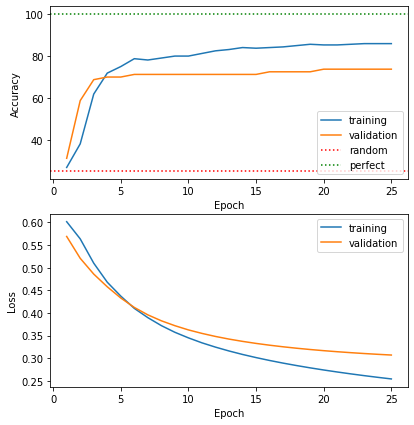

In [34]:
plot_learning_curve(learning_curve)

## System Utilization

While a model is training, you may want to confirm that's it's making full use of your hardware. If it isn't, that's a sign that you can do things like train larger batches, a larger model, or do more things in parallel.

`nvidia-smi` shows information about the GPUs in your system and their memory/processor usage.

`top` is a commonly-used linux command showing the most active processes.

In [35]:
!nvidia-smi

Tue Aug 23 17:15:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   35C    P0    38W / 300W |   2033MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [36]:
!top -n 1

=top - 17:15:28 up 26 min,  0 users,  load average: 2.37, 1.67, 1.58
Tasks:  11 total,   1 running,  10 sleeping,   0 stopped,   0 zombie
%Cpu(s):  0.8 us,  0.8 sy,  0.0 ni, 98.3 id,  0.0 wa,  0.0 hi,  0.0 si,  0.0 st
MiB Mem :  61287.0 total,  19621.6 free,   4302.5 used,  37362.9 buff/cache
MiB Swap:      0.0 total,      0.0 free,      0.0 used.  56305.8 avail Mem 

    PID USER      PR  NI    VIRT    RES    SHR S  %CPU  %MEM     TIME+ COMMAND  
      1 root      20   0    8844   3656   3280 S   0.0   0.0   0:00.10 runLaun+ 
    277 ubuntu    20   0    8844   3932   3528 S   0.0   0.0   0:00.01 command+ 
    331 ubuntu    20   0    7120   3580   3232 S   0.0   0.0   0:00.00 start    
    334 ubuntu    20   0    8844   1768   1364 S   0.0   0.0   0:00.00 command+ 
    335 ubuntu    20   0    8844   1768   1364 S   0.0   0.0   0:00.00 command+ 
    336 ubuntu    20   0    5508    540    464 S   0.0   0.0   0:00.00 tee      
    339 ubuntu    20   0    5508    536    456 S   0.0   0.0 

## Cleanup

You may occasionally need to run the following command to clear cached data from the GPU between model trainings.

This does not affect our cache of pretransformed images, since those were saved to disk.

If you see high memory usage in the `nvidia-smi` output above you can try running it and then running `nvidia-smi` again to see the difference.

In [37]:
torch.cuda.empty_cache()